# Oxygen consumption analysis

In [50]:
%matplotlib inline

In [51]:
import os
import os.path as op
import cPickle as pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.close('all')
datadir = op.join(os.getcwd(), 'data')
#Oxygen consumption data
with open(op.join(datadir, 'o2data.pkl'), 'rb') as INPUT:
    dfo2 = pickle.load(INPUT)
#Mitochondrial Network  Topology data
with open(op.join(datadir, 'munged_dataframe.pkl'), 'rb') as INPUT:
    df = pickle.load(INPUT)
#Mitochondrial tubule heterogeneity data    
with open(op.join(datadir, 'lagedges.pkl'), 'rb') as INPT:
    dflags = pickle.load(INPT)
df['lags_1'] = dflags
#Cell size data
with open(op.join(datadir, 'cellVolume.pkl'), 'rb') as INPT:
    dfsize = pickle.load(INPT)
    dfsize.index = dfsize.cell

Set defaults for plotting

In [52]:
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['savefig.dpi'] = 100
sns.set(style='whitegrid', context='paper', 
        rc={'patch.linewidth':1,
            'patch.edgecolor':(.25,.25,.25),
            'lines.linewidth': 1})

Dataframe and bins initialization

In [53]:
dfvol = pd.DataFrame({'Vol': dfsize.loc[:, 'Vol'],
                      'mitolen': df.loc[:, 'mito_totlen'],
                      'media': df.loc[:, 'media']})

dfvol['mitovol'] = np.pi * (.15)**2 * dfvol.mitolen
dfvol['Vol Ratio'] = dfvol.mitovol / dfvol.Vol

#   Topology  (by cell)
dfcellcon = df.ix[:, ['mito_cell_avedyr',
                      'cell_coefvar_r',
                      'mito_beta_geo',
                      'mito_beta_top',
                      'mito_phi',
                      'mito_pk3',
                      'mito_avgdeg',
                      'mito_edgenum']]
dfcellcon = pd.concat([dfcellcon,
                       dfvol.loc[:, 'Vol Ratio'],
                       df.loc[:, 'media']], axis=1)
dfcellcon = dfcellcon[dfcellcon.mito_cell_avedyr <= 2000]  # exclude hi YPE's
dfcellcon[r'$\Delta \Psi$ Unscaled'] = dfcellcon["mito_cell_avedyr"]
dfcellcon['Number of Edges'] = dfcellcon.mito_edgenum
dfcellcon['Average Degree'] = dfcellcon.mito_avgdeg
dfcellcon['O2 per mito vol'] = ''
dfcellcon['OCR per cell'] = ''

Plotting O2 respiration rate and mitochondrial volume ratio as a function of carbon sources show that cells in fermentation conditions (YPD) have lower mitochondrial respiration rate and content. For cells grown in respiratory conditions (YPE, YPL and YPR) the relationship between mitochondrial content and respiration levels is mixed.

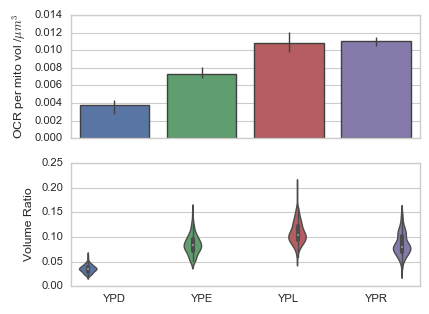

In [54]:
f, (ax1, ax0) = plt.subplots(2, 1,
                             figsize=(4.5, 3.5),
                             sharex=True)
sns.violinplot('media',
               'Vol Ratio',
               data=dfcellcon,
               hue='media',
               ax=ax0)
ax0.set_xlabel('')
ax0.set_ylabel('Volume Ratio')
ax0.get_legend().set_visible(False)

A = dfo2.groupby('type').quantile(0.025).values.flatten()
B = dfo2.groupby('type').quantile(0.975).values.flatten()
C = dfo2.groupby('type').quantile(0.5).values.flatten()
g = sns.barplot(x='type',
                y='OCRmito',
                estimator=np.median,
                ci=None,
                ecolor=[.25, .25, .25],
                data=dfo2,
                yerr=[C-A, B-C],
                ax=ax1)
ax1.set_ylabel(r'OCR per mito vol /$\mu m^{3}$')
ax1.set_xlabel('')


Cells in fermentation conditions (YPD) have lower mitochondrial ΔΨ, O2 and mitochondrial content compared to those in respiration. For cells grown in respiratory conditions (YPE, YPL and YPR) the relationship between mitochondrial content, respiration and ΔΨ is mixed.

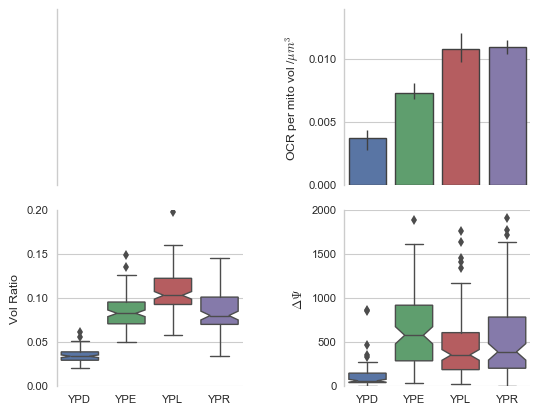

In [55]:
f, ([ax0, ax1], [ax3, ax2]) = plt.subplots(2, 2,
                                  figsize=(5.5, 4.25),
                                  sharex=True)
ax0.yaxis.set_visible(False)
ax0.grid(False)


g = sns.barplot(x='type',
                y='OCRmito',
                estimator=np.median,
                ci=None,
                ecolor=[.25, .25, .25],
                data=dfo2,
                yerr=[C-A, B-C],
                ax=ax1)

ax1.set_ylabel(r'OCR per mito vol /$\mu m^{3}$')
ax1.set_xlabel('')
ax1.set_yticks(np.arange(0, .015, .005))

sns.boxplot('media',
               'mito_cell_avedyr',
               data=dfcellcon,
               notch=True,
               #hue='media',
               ax=ax2)
ax2.set_ylabel(r'$\Delta \Psi$ ')
ax2.set_ylim(0, 2000)
ax2.set_xlabel('')
#ax2.get_legend().set_visible(False)

sns.boxplot('media',
               'Vol Ratio',
               data=dfcellcon,
               #hue='media',
               notch=True,
               #estimator=np.median,
               ax=ax3)
ax3.set_ylabel('Vol Ratio')
ax3.set_ylim(0)
ax3.set_xlabel('')
#ax3.get_legend().set_visible(False)
sns.despine(bottom=True)
plt.tight_layout(w_pad=3)
plt.savefig('panel.svg')
